In [18]:
import pandas as pd
import numpy as np

In [19]:
df = pd.read_csv('../data/processed/dataset_analitico.csv')

In [20]:
df.columns

Index(['user_id', 'year_month', 'total_calls', 'total_duration',
       'avg_duration', 'total_mb', 'sessions_count', 'total_messages',
       'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'usd_monthly_pay', 'usd_per_gb', 'usd_per_message',
       'usd_per_minute'],
      dtype='object')

In [61]:
# Feature engineering con ayuda de claude sonnet 3.7
df_fe = df.copy()

# Convert date columns to datetime
df_fe['reg_date'] = pd.to_datetime(df_fe['reg_date'])
df_fe['churn_date'] = pd.to_datetime(df_fe['churn_date'])
df_fe['year_month'] = pd.to_datetime(df_fe['year_month'] + '-01')

# Flag for churned users (not '2099-12-31')
df_fe['is_churned'] = (df_fe['churn_date'] != pd.to_datetime('2099-12-31')).astype(int)

# Calculate extra usage beyond plan limits
df_fe['extra_minutes'] = np.maximum(0, df_fe['total_duration'] - df_fe['minutes_included'])
df_fe['extra_messages'] = np.maximum(0, df_fe['total_messages'] - df_fe['messages_included'])
df_fe['extra_mb'] = np.maximum(0, df_fe['total_mb'] - df_fe['mb_per_month_included'])

# Usage ratios (% of plan used)
df_fe['minutes_usage_ratio'] = df_fe['total_duration'] / df_fe['minutes_included']
df_fe['messages_usage_ratio'] = df_fe['total_messages'] / df_fe['messages_included']
df_fe['mb_usage_ratio'] = df_fe['total_mb'] / df_fe['mb_per_month_included']

# Calculate cost for extra usage
df_fe['extra_minutes_cost'] = df_fe['extra_minutes'] * df_fe['usd_per_minute']
df_fe['extra_messages_cost'] = df_fe['extra_messages'] * df_fe['usd_per_message']
df_fe['extra_mb_cost'] = (df_fe['extra_mb'] / 1024) * df_fe['usd_per_gb']  # Convert MB to GB

# Expected total cost
df_fe['total_cost'] = (df_fe['usd_monthly_pay'] + 
                          df_fe['extra_minutes_cost'] + 
                          df_fe['extra_messages_cost'] + 
                          df_fe['extra_mb_cost'])

df_fe = df_fe.drop(['minutes_included', 'messages_included', 'mb_per_month_included', 'usd_per_minute', 'usd_per_message', 'usd_per_gb'], axis=1)

# Extract region from city
# df_fe['region'] = df_fe['city'].str.split(',').str[1].str.strip()
# df_fe = pd.get_dummies(df_fe, columns=['region'], prefix='region')
df_fe = df_fe.drop('city', axis=1)

# One-hot encode plan
df_fe = pd.get_dummies(df_fe, columns=['plan'], prefix='plan')

# User behavior patterns
df_fe['calls_per_session'] = df_fe['total_calls'] / np.maximum(1, df_fe['total_calls'])
df_fe['mb_per_session'] = df_fe['total_mb'] / np.maximum(1, df_fe['sessions_count'])
df_fe['messages_per_session'] = df_fe['total_messages'] / np.maximum(1, df_fe['total_messages'])
df_fe = df_fe.drop(['total_duration', 'total_messages', 'total_mb'], axis=1)

# Age groups
df_fe['age_group'] = pd.cut(df_fe['age'], bins=[0, 18, 25, 35, 50, 100], labels=['<18', '18-25', '26-35', '36-50', '50+'])
df_fe = pd.get_dummies(df_fe, columns=['age_group'], prefix='age')
df_fe = df_fe.drop('age', axis=1)

df_fe['lag1_total_cost'] = df_fe['total_cost'].shift(1)
df_fe['lag2_total_cost'] = df_fe['total_cost'].shift(2)
df_fe['lag1_total_cost'] = df_fe['lag1_total_cost'].fillna(0)
df_fe['lag2_total_cost'] = df_fe['lag2_total_cost'].fillna(0)

# Display shape comparison
print(f"Original DataFrame: {df.shape[1]} columns")
print(f"Feature Engineered DataFrame: {df_fe.shape[1]} columns")

Original DataFrame: 22 columns
Feature Engineered DataFrame: 33 columns


In [62]:
print(df_fe.columns)
df_fe.to_csv('../data/ml/dataset_ml.csv', index=False)

Index(['user_id', 'year_month', 'total_calls', 'avg_duration',
       'sessions_count', 'first_name', 'last_name', 'reg_date', 'churn_date',
       'usd_monthly_pay', 'is_churned', 'extra_minutes', 'extra_messages',
       'extra_mb', 'minutes_usage_ratio', 'messages_usage_ratio',
       'mb_usage_ratio', 'extra_minutes_cost', 'extra_messages_cost',
       'extra_mb_cost', 'total_cost', 'plan_surf', 'plan_ultimate',
       'calls_per_session', 'mb_per_session', 'messages_per_session',
       'age_<18', 'age_18-25', 'age_26-35', 'age_36-50', 'age_50+',
       'lag1_total_cost', 'lag2_total_cost'],
      dtype='object')


Top 10 features positively correlated with total_cost:
extra_mb           0.884122
extra_mb_cost      0.880445
total_mb           0.765835
mb_usage_ratio     0.675051
sessions_count     0.563998
lag1_total_cost    0.392615
mb_per_session     0.297413
total_calls        0.219581
total_duration     0.210039
extra_minutes      0.197780
Name: total_cost, dtype: float64

Top 10 features negatively correlated with total_cost:
minutes_usage_ratio     0.100052
messages_usage_ratio    0.078586
messages_per_session    0.004406
is_churned             -0.013118
user_id                -0.015685
avg_duration           -0.055606
calls_per_session      -0.069720
usd_per_message        -0.151448
usd_per_minute         -0.151448
usd_per_gb             -0.151448
Name: total_cost, dtype: float64

Selected 23 features based on correlation > 0.1:
['total_cost', 'extra_mb', 'extra_mb_cost', 'total_mb', 'mb_usage_ratio', 'sessions_count', 'lag1_total_cost', 'mb_per_session', 'total_calls', 'total_duration', '

<Figure size 1200x1000 with 0 Axes>

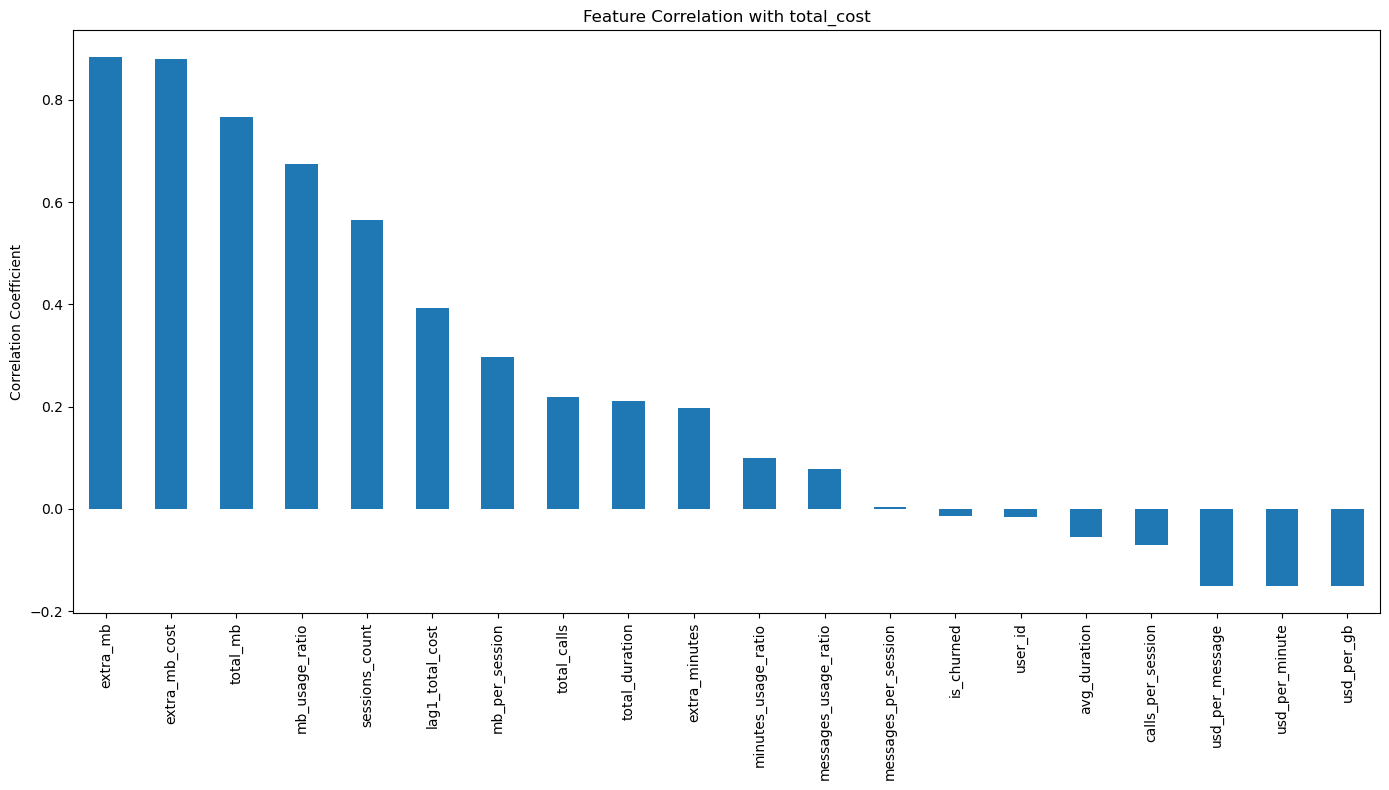

In [ ]:
# Feature selection hecho con ayuda de claude sonnet 3.7
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

correlation_with_target = df_fe.select_dtypes(include=['float64', 'int64']).corr()['total_cost'].sort_values(ascending=False)

# Display top positive and negative correlations
print("Top 10 features positively correlated with total_cost:")
print(correlation_with_target[1:11])  # Skip the first one as it's the target itself
print("\nTop 10 features negatively correlated with total_cost:")
print(correlation_with_target[-10:])

# Plot correlation of top features with target
plt.figure(figsize=(14, 8))
top_corr = pd.concat([correlation_with_target[1:11], correlation_with_target[-10:]])
top_corr.plot(kind='bar')
plt.title('Feature Correlation with total_cost')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()

correlation_threshold = 0.1
selected_features = correlation_with_target[abs(correlation_with_target) > correlation_threshold].index.tolist()

print(f"\nSelected {len(selected_features)} features based on correlation > {correlation_threshold}:")
print(selected_features)

df_fe = df_fe[selected_features]